In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 4GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
#Necessary libraries
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D, BatchNormalization
import numpy as np
import skimage
import random
from tensorflow.keras.optimizers import Adam
import Denoise_layer # The custom built CVXPY layer
import matplotlib.pyplot as plt

In [3]:
#Getting the MNIST dataset
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
x_train.shape,y_train.shape,x_test.shape,y_test.shape #Shapes of the variables

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [5]:
#number of samples taken
train_num = 10000
test_num = 2000

In [6]:
#slicing the data
x_train = x_train[:train_num]
y_train = y_train[:train_num]
x_test = x_test[:test_num]
y_test = y_test[:test_num]

In [7]:
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((10000, 28, 28), (10000,), (2000, 28, 28), (2000,))

In [8]:
y_test.shape

(2000,)

In [9]:
#Finding total number of images in training and test set
print(len(x_train))
print(len(x_test))

10000
2000


In [10]:
#normalizing the entire data
x_train = x_train/255.0
x_test = x_test/255.0

In [11]:
#Reshaping and Normalizing training and test images
x_train = x_train.reshape(train_num, 28, 28, 1)

x_test = x_test.reshape(test_num, 28, 28, 1)


In [12]:
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((10000, 28, 28, 1), (10000,), (2000, 28, 28, 1), (2000,))

In [13]:
epochs = 10
batchSize = 32
opt = Adam(learning_rate=0.001)

In [14]:
#VGG model Building using Keras
def VGG16model():
  model = Sequential()

  model.add(Conv2D(32, 3, activation='relu', padding='same', input_shape=(28, 28, 1)))
  model.add(Conv2D(64, 3, activation='relu', padding='same'))
  model.add(MaxPooling2D(2, 2))
  model.add(BatchNormalization())

  model.add(Conv2D(128, 3, activation='relu', padding='same'))
  model.add(Conv2D(128, 3, activation='relu', padding='same'))
  model.add(MaxPooling2D(2, 2))
  model.add(BatchNormalization())

  model.add(Conv2D(256, 3, activation='relu', padding='same'))
  model.add(Conv2D(256, 3, activation='relu', padding='same'))
  model.add(Conv2D(256, 3, activation='relu', padding='same'))
  model.add(MaxPooling2D(2, 2))
  model.add(BatchNormalization())

  model.add(Conv2D(512, 3, activation='relu', padding='same'))
  model.add(Conv2D(512, 3, activation='relu', padding='same'))
  model.add(Conv2D(512, 3, activation='relu', padding='same'))
  model.add(MaxPooling2D(2, 1)) # default stride is 2
  model.add(BatchNormalization())

  model.add(Conv2D(512, 3, activation='relu', padding='same'))
  model.add(Conv2D(512, 3, activation='relu', padding='same'))
  model.add(Conv2D(512, 3, activation='relu', padding='same'))
  model.add(MaxPooling2D(2, 1)) # default stride is 2
  model.add(BatchNormalization())

  model.add(Flatten())
  model.add(Dense(4096, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(4096, activation='relu'))
  model.add(Dropout(0.5))

  model.add(Dense(10, activation='softmax'))
  model.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=['accuracy'])
  return model

In [15]:
#The instance for the cvxpy layer
def CVXPYmodel(inp_shape, lam):
    
    denoise = Denoise_layer.Denoise(input_shape=inp_shape,lam_val=lam,trainable=False)
    model = Sequential()
    model.add(denoise)
    model.compile()
    
    return model 

In [16]:
from sklearn.metrics import classification_report,confusion_matrix

### Model-5
+ Noise level= 0.3

In [17]:
import skimage
import matplotlib.pyplot as plt

In [18]:
#Adding noise to the dataset with the level
import skimage
noise_lvl_2 = 0.3
noise_x_train_2 = np.array([skimage.util.random_noise(x, mode='gaussian', seed=42, clip=True, var = noise_lvl_2)  for x in x_train])
noise_x_test_2 = np.array([skimage.util.random_noise(x, mode='gaussian', seed=42, clip=True, var = noise_lvl_2) for x in x_test])

In [19]:
model_5 = VGG16model()

In [20]:
history_5 = model_5.fit(noise_x_train_2, y_train, epochs = epochs, batch_size = batchSize)#training the model

C:\Users\phvpa\anaconda3\envs\CVXPY\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Epoch 1/10
313/313 [==============================] - 25s 47ms/step - loss: 1.7197 - accuracy: 0.5355
Epoch 2/10
313/313 [==============================] - 10s 33ms/step - loss: 0.3561 - accuracy: 0.8945
Epoch 3/10
313/313 [==============================] - 10s 33ms/step - loss: 0.3195 - accuracy: 0.9154
Epoch 4/10
313/313 [==============================] - 11s 36ms/step - loss: 0.2574 - accuracy: 0.9340
Epoch 5/10
313/313 [==============================] - 10s 33ms/step - loss: 0.2969 - accuracy: 0.9302
Epoch 6/10
313/313 [==============================] - 10s 33ms/step - loss: 0.2385 - accuracy: 0.9452
Epoch 7/10
313/313 [==============================] - 10s 33ms/step - loss: 0.2258 - accuracy: 0.9465
Epoch 8/10
313/313 [==============================] - 11s 34ms/step - loss: 0.2657 - accuracy: 0.9436
Epoch 9/10
313/313 [==============================] - 10s 33ms/step - loss: 0.3020 - accuracy: 0.9332
Epoch 10/10
313/313 [==============================] - 10s 33ms/step - loss: 0.163

In [21]:
#Function for showing the accuracy and loss plots
def ShowPlots(hist):
  plt.figure(figsize=(16,6))
  plt.subplot(121)
  plt.plot(hist.history["accuracy"],'-ro',label="Accuracy")
  #plt.plot(hist.history["val_accuracy"],'-bo',label="Validation Accuracy")
  plt.legend()
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.subplot(122)
  plt.plot(hist.history["loss"],'-ro',label="Loss")
  #plt.plot(hist.history["val_loss"],'-bo',label="Validation Loss")
  plt.legend()
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  return plt.show()

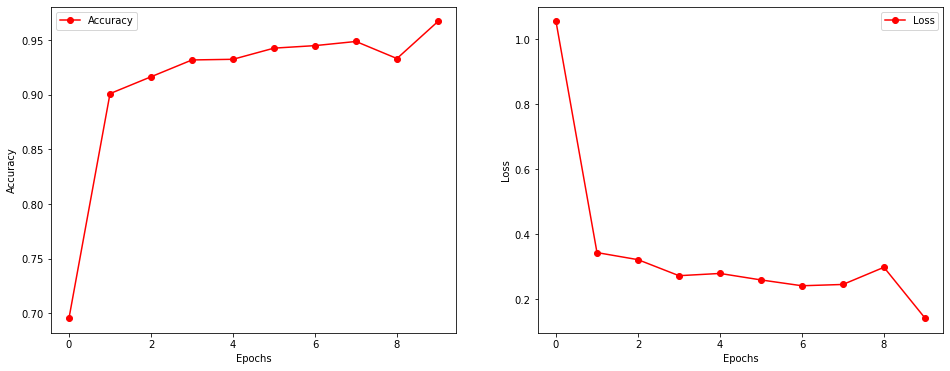

In [22]:
ShowPlots(history_5)

In [23]:
y_pred_5 = model_5.predict(noise_x_test_2)
y_pred_5 = np.argmax(y_pred_5,axis=1)

In [24]:
confusion_matrix(y_test,y_pred_5)

array([[174,   0,   0,   0,   0,   0,   1,   0,   0,   0],
       [  0, 233,   0,   0,   0,   0,   0,   1,   0,   0],
       [  0,   1, 215,   1,   0,   0,   0,   2,   0,   0],
       [  7,   0,   1, 198,   0,   1,   0,   0,   0,   0],
       [  1,   1,   1,   0, 212,   0,   1,   0,   0,   1],
       [113,   1,   0,   2,   1,  61,   0,   1,   0,   0],
       [  4,   0,   0,   0,   0,   1, 173,   0,   0,   0],
       [  0,   5,   5,   0,   0,   0,   0, 195,   0,   0],
       [  2,   2,   5,   4,   0,   0,   1,   2, 173,   3],
       [  0,   1,   0,   6,   9,   1,   0,   2,   0, 175]], dtype=int64)

In [25]:
print(classification_report(y_test,y_pred_5))#classification report

              precision    recall  f1-score   support

           0       0.58      0.99      0.73       175
           1       0.95      1.00      0.97       234
           2       0.95      0.98      0.96       219
           3       0.94      0.96      0.95       207
           4       0.95      0.98      0.97       217
           5       0.95      0.34      0.50       179
           6       0.98      0.97      0.98       178
           7       0.96      0.95      0.96       205
           8       1.00      0.90      0.95       192
           9       0.98      0.90      0.94       194

    accuracy                           0.90      2000
   macro avg       0.92      0.90      0.89      2000
weighted avg       0.93      0.90      0.90      2000



### Model-6
+ noise level = 0.3
+ lamda value = 0.1

In [26]:
cvxpy_layer_1 = CVXPYmodel((28,28),0.1)#making the cvxpy model

In [27]:
denoised_train_1 = cvxpy_layer_1.predict(noise_x_train_2.reshape(train_num,28,28)) #Denoising the input images

C:\Users\phvpa\anaconda3\envs\CVXPY\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


In [28]:
denoised_train_1.shape

(10000, 28, 28, 1)

In [29]:
model_6 = VGG16model()

In [30]:
history_6 = model_6.fit(denoised_train_1,y_train,epochs= epochs,batch_size= batchSize)#training the model with the denoised data

Epoch 1/10
313/313 [==============================] - 12s 38ms/step - loss: 8.7266 - accuracy: 0.1778
Epoch 2/10
313/313 [==============================] - 14s 44ms/step - loss: 1.6654 - accuracy: 0.3796
Epoch 3/10
313/313 [==============================] - 12s 37ms/step - loss: 1.2357 - accuracy: 0.5638
Epoch 4/10
313/313 [==============================] - 15s 48ms/step - loss: 0.8784 - accuracy: 0.7315
Epoch 5/10
313/313 [==============================] - 11s 36ms/step - loss: 0.8130 - accuracy: 0.7531
Epoch 6/10
313/313 [==============================] - 11s 37ms/step - loss: 0.6014 - accuracy: 0.8263
Epoch 7/10
313/313 [==============================] - 12s 37ms/step - loss: 0.5429 - accuracy: 0.8528
Epoch 8/10
313/313 [==============================] - 12s 37ms/step - loss: 0.3561 - accuracy: 0.9059
Epoch 9/10
313/313 [==============================] - 11s 37ms/step - loss: 0.4051 - accuracy: 0.8983
Epoch 10/10
313/313 [==============================] - 12s 37ms/step - loss: 0.292

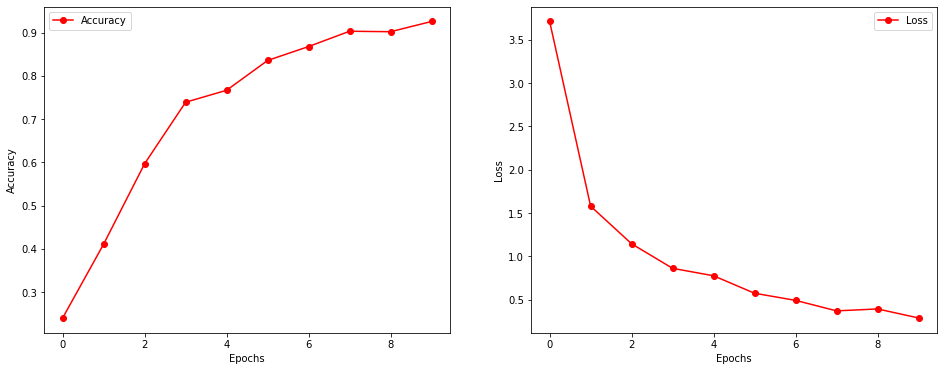

In [31]:
ShowPlots(history_6)

In [32]:
denoised_test_1 = cvxpy_layer_1.predict(noise_x_test_2.reshape(test_num,28,28))#Denoising the input images

In [33]:
denoised_test_1.shape

(2000, 28, 28, 1)

In [34]:
y_pred_6 = model_6.predict(denoised_test_1) #Predicting the denoised test data
y_pred_6 =np.argmax(y_pred_6,axis=1)

In [35]:
confusion_matrix(y_test,y_pred_6)

array([[170,   0,   0,   0,   2,   0,   2,   0,   1,   0],
       [  0, 227,   0,   3,   0,   0,   0,   0,   4,   0],
       [  0,   0, 211,   0,   0,   0,   2,   2,   4,   0],
       [  0,   0,  12, 190,   0,   1,   0,   3,   0,   1],
       [  0,   0,   0,   0, 200,   0,   6,   0,   0,  11],
       [  0,   0,   0,  12,   0, 163,   0,   1,   0,   3],
       [  3,   0,   0,   0,   1,   4, 168,   0,   1,   1],
       [  1,   0,   6,   0,   0,   0,   0, 194,   0,   4],
       [  3,   1,   4,   2,   0,   4,   0,   0, 163,  15],
       [  1,   0,   0,   6,   1,   0,   0,   2,   5, 179]], dtype=int64)

In [36]:
print(classification_report(y_test,y_pred_6))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       175
           1       1.00      0.97      0.98       234
           2       0.91      0.96      0.93       219
           3       0.89      0.92      0.90       207
           4       0.98      0.92      0.95       217
           5       0.95      0.91      0.93       179
           6       0.94      0.94      0.94       178
           7       0.96      0.95      0.95       205
           8       0.92      0.85      0.88       192
           9       0.84      0.92      0.88       194

    accuracy                           0.93      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.93      0.93      0.93      2000



In [37]:
import math 
import numpy as np 
#function for calculating the PSNR value
def calculate_psnr(img1, img2): 
    # img1 and img2 have range [0, 255] 
    img1 = img1.astype(np.float64) 
    img2 = img2.astype(np.float64) 
    mse = np.mean((img1 - img2)**2) 
    if mse == 0:
        return float('inf') 
    return 20 * math.log10(1.0 / math.sqrt(mse))

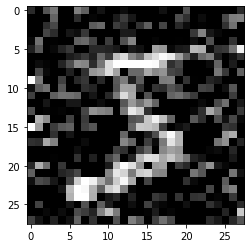

In [38]:
plt.imshow(denoised_train_1[0],cmap='gray')

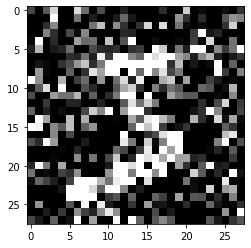

In [39]:
plt.imshow(noise_x_train_2[0],cmap='gray')

In [40]:
calculate_psnr(x_train[0],denoised_train_1[0])#1

12.310198439856979

In [41]:
calculate_psnr(x_train[0],noise_x_train_2[0]) #1

9.129734078556682

In [42]:
psnr_denoised_1 = 0
for i,j in zip(x_train,denoised_train_1):
    psnr_denoised_1 = calculate_psnr(i,j) + psnr_denoised_1
psnr_denoised_1 = psnr_denoised_1/x_train.shape[0]
psnr_denoised_1

11.91903287538884

In [43]:
psnr_noised_1 = 0
for i,j in zip(x_train,noise_x_train_2):
    psnr_noised_1 = calculate_psnr(i,j) + psnr_noised_1
psnr_noised_1 = psnr_noised_1/x_train.shape[0]
psnr_noised_1

8.92698713430124

### Model-7
+ noise level = 0.3
+ lambda value = 0.3

In [44]:
cvxpy_layer_2 = CVXPYmodel((28,28),0.3) #instance for cvxpy model

In [45]:
denoised_train_2 = cvxpy_layer_2.predict(noise_x_train_2.reshape(train_num,28,28)) #Denoising the input images

C:\Users\phvpa\anaconda3\envs\CVXPY\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


In [46]:
model_7 = VGG16model()

In [47]:
history_7 = model_7.fit(denoised_train_2,y_train,epochs= epochs,batch_size= batchSize)#training with the denoised images

Epoch 1/10
313/313 [==============================] - 12s 38ms/step - loss: 8.5875 - accuracy: 0.1083
Epoch 2/10
313/313 [==============================] - 11s 36ms/step - loss: 2.1978 - accuracy: 0.1985
Epoch 3/10
313/313 [==============================] - 12s 39ms/step - loss: 2.2071 - accuracy: 0.2084
Epoch 4/10
313/313 [==============================] - 12s 38ms/step - loss: 2.0188 - accuracy: 0.2907
Epoch 5/10
313/313 [==============================] - 11s 35ms/step - loss: 1.9436 - accuracy: 0.3218
Epoch 6/10
313/313 [==============================] - 11s 36ms/step - loss: 1.5726 - accuracy: 0.4168
Epoch 7/10
313/313 [==============================] - 11s 36ms/step - loss: 1.2283 - accuracy: 0.5623
Epoch 8/10
313/313 [==============================] - 11s 36ms/step - loss: 1.0020 - accuracy: 0.6521
Epoch 9/10
313/313 [==============================] - 11s 36ms/step - loss: 0.7111 - accuracy: 0.7753
Epoch 10/10
313/313 [==============================] - 11s 35ms/step - loss: 0.531

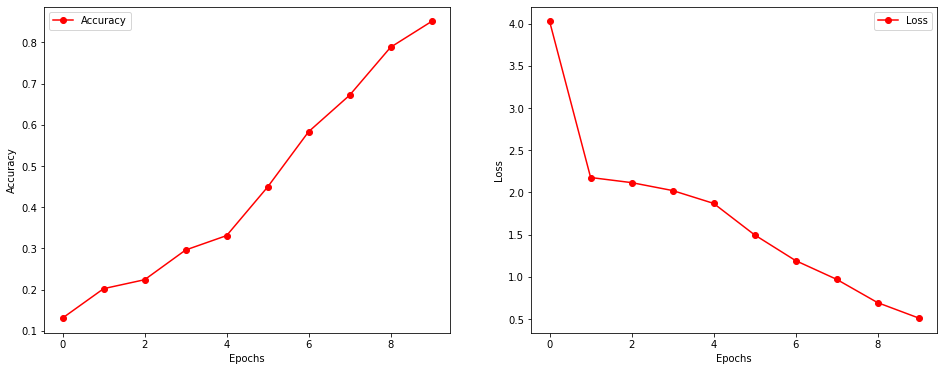

In [48]:
ShowPlots(history_7)

In [49]:
denoised_test_2 = cvxpy_layer_2.predict(noise_x_test_2.reshape(test_num,28,28)) #Denoising the input images-test

In [50]:
y_pred_7 = model_7.predict(denoised_test_2)#Predicting the denoised test data
y_pred_7 = np.argmax(y_pred_7,axis=1)

In [51]:
confusion_matrix(y_test,y_pred_7)#confusion matrix

array([[159,   0,  11,   0,   0,   0,   1,   0,   4,   0],
       [  0, 207,   7,   7,   0,   0,   0,  11,   2,   0],
       [  1,   0, 212,   5,   0,   0,   0,   0,   1,   0],
       [  0,   0,   4, 203,   0,   0,   0,   0,   0,   0],
       [  1,   0,   1,   1, 139,   0,   5,   0,  53,  17],
       [  0,   0,   1,  94,   0,  63,   0,   0,  21,   0],
       [ 14,   0,   0,   0,   1,   0, 126,   0,  37,   0],
       [  0,   0,   5,  27,   0,   0,   0, 173,   0,   0],
       [  0,   0,  11,  47,   0,   0,   0,   0, 134,   0],
       [  0,   0,   3,  44,   0,  20,   0,  13,  21,  93]], dtype=int64)

In [52]:
print(classification_report(y_test,y_pred_7))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91       175
           1       1.00      0.88      0.94       234
           2       0.83      0.97      0.89       219
           3       0.47      0.98      0.64       207
           4       0.99      0.64      0.78       217
           5       0.76      0.35      0.48       179
           6       0.95      0.71      0.81       178
           7       0.88      0.84      0.86       205
           8       0.49      0.70      0.58       192
           9       0.85      0.48      0.61       194

    accuracy                           0.75      2000
   macro avg       0.81      0.75      0.75      2000
weighted avg       0.82      0.75      0.76      2000



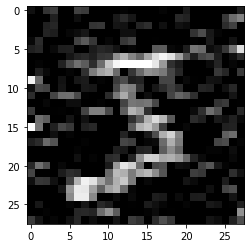

In [53]:
plt.imshow(denoised_train_2[0],cmap='gray')#denoised image

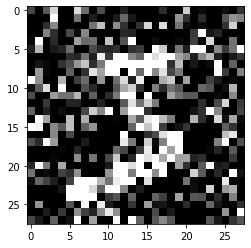

In [54]:
plt.imshow(noise_x_train_2[0],cmap='gray')#noise image

In [55]:
calculate_psnr(x_train[0],denoised_train_2[0])#1

13.330825513459093

In [56]:
calculate_psnr(x_train[0],noise_x_train_2[0])

9.129734078556682

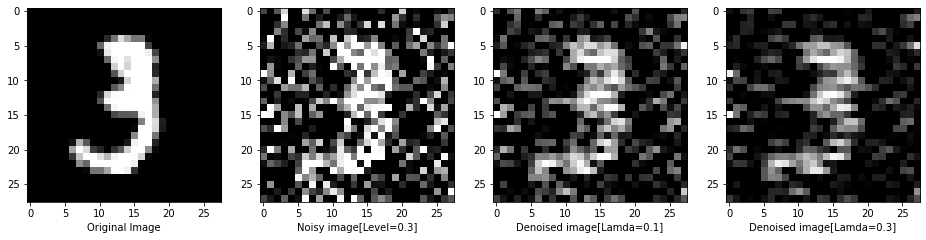

In [57]:
fig = plt.figure(figsize=(16,8))

plt.subplot(1, 4, 1)
plt.imshow(x_train[10].reshape(28,28),cmap='gray')
plt.xlabel("Original Image")
plt.subplot(1, 4, 2)
plt.imshow(noise_x_train_2[10].reshape(28,28),cmap='gray')
plt.xlabel("Noisy image[Level=0.3]")
plt.subplot(1, 4, 3)
plt.imshow(denoised_train_1[10].reshape(28,28),cmap='gray')
plt.xlabel("Denoised image[Lamda=0.1]")
plt.subplot(1, 4, 4)
plt.imshow(denoised_train_2[10].reshape(28,28),cmap='gray')
plt.xlabel("Denoised image[Lamda=0.3]")
plt.show()